In [1]:
import librosa
import numpy as np
import os

In [2]:
import librosa.display
import matplotlib.pyplot as plt

In [3]:
def load_files(directory_path):
    audio_files = []
    for filename in os.listdir(directory_path):
        if filename.endswith('.wav'):  
            file_path = os.path.join(directory_path, filename) 
            signal, sample_rate = librosa.load(file_path, sr=None)  
            audio_files.append((filename, signal, sample_rate))
    return audio_files

In [4]:

def calculate_mfccs(audio_files):
    mfccs_dict = {}
    for filename, signal, sample_rate in audio_files:
        mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=13)
        mfccs_transposed = mfccs.T
        mfccs_dict[filename] = mfccs_transposed
    return mfccs_dict

In [5]:
def plot_mfcc_heatmap(mfccs_dict , audio_files , i):
    filename = audio_files[i][0]
    sr = audio_files[i][2]
    mfccs = mfccs_dict[filename]

    plt.figure(figsize=(10, 4))

    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    
    plt.title(f'MFCCs for {filename}')
    plt.xlabel('Time')
    plt.ylabel('MFCC coefficients')
    plt.colorbar(format='%+2.0f dB')
    plt.show()


In [6]:
hiphop_directory_path = './data/hiphop'
hiphop_audio_files = load_files(hiphop_directory_path)
hiphop_mfccs = calculate_mfccs(hiphop_audio_files)

metal_directory_path = './data/metal'
metal_audio_files = load_files(metal_directory_path)
metal_mfccs = calculate_mfccs(metal_audio_files)

pop_directory_path = './data/pop'
pop_audio_files = load_files(pop_directory_path)
pop_mfccs = calculate_mfccs(pop_audio_files)

blues_directory_path = './data/blues'
blues_audio_files = load_files(blues_directory_path)
blues_mfccs = calculate_mfccs(blues_audio_files)

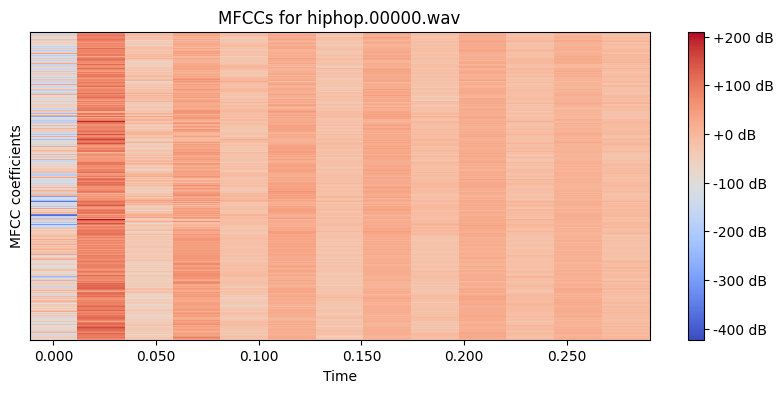

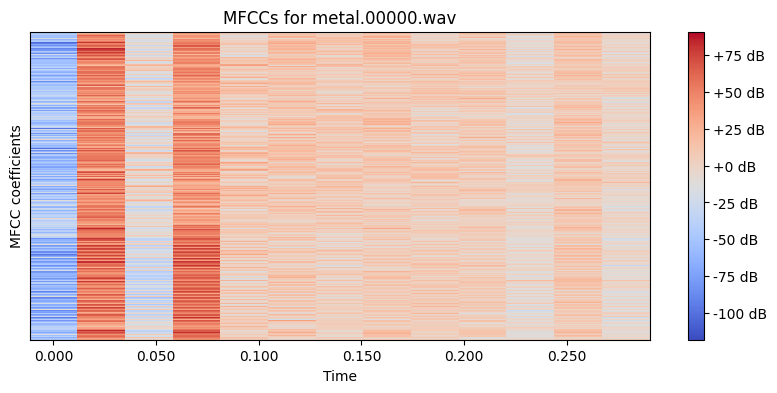

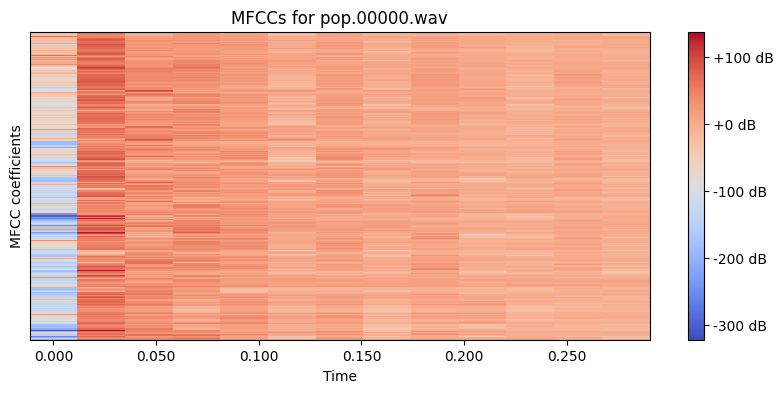

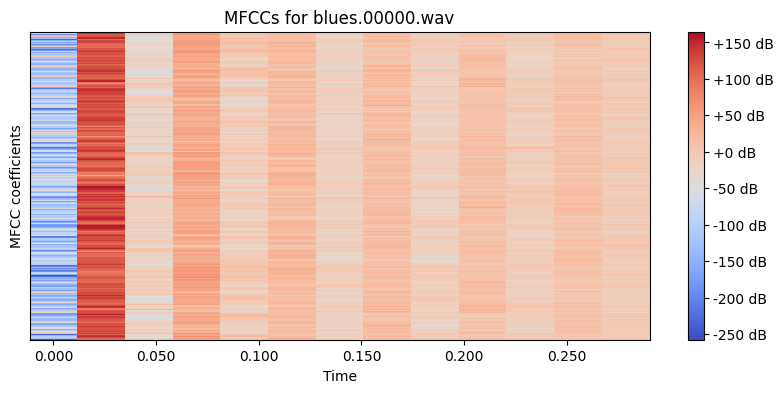

In [7]:
plot_mfcc_heatmap(hiphop_mfccs , hiphop_audio_files , 0)
plot_mfcc_heatmap(metal_mfccs , metal_audio_files , 0)
plot_mfcc_heatmap(pop_mfccs , pop_audio_files , 0)
plot_mfcc_heatmap(blues_mfccs , blues_audio_files , 0)

In [8]:
def find_min (mfccs_dict , audio_files):
    filename = audio_files[0][0]
    mfccs = mfccs_dict[filename]
    min_len = len(mfccs)
    for i in range(1 , len(audio_files)):
        filename = audio_files[i][0]
        mffcs = mfccs_dict[filename]
        temp_len = len(mffcs)
        if (min_len > temp_len) :
            min_len = temp_len
    return min_len

def resize_mfccs(mfccs_dict, target_size):
    resized_mfccs_dict = {}
    for filename, mfccs in mfccs_dict.items():
        if mfccs.shape[0] > target_size:
            resized_mfccs_dict[filename] = mfccs[:target_size, :]
        else:
            resized_mfccs_dict[filename] = mfccs
    return resized_mfccs_dict

min_len = min ([find_min(pop_mfccs , pop_audio_files) , find_min(hiphop_mfccs , hiphop_audio_files) , find_min(metal_mfccs , metal_audio_files) , find_min(blues_mfccs , blues_audio_files)] )
hiphop_mfccs_resized = resize_mfccs(hiphop_mfccs, min_len)
metal_mfccs_resized = resize_mfccs(metal_mfccs, min_len)
pop_mfccs_resized = resize_mfccs(pop_mfccs, min_len)
blues_mfccs_resized = resize_mfccs(blues_mfccs, min_len)

In [9]:
def split (mfccs_dict , audio_files):
    train = {}
    test = {}
    for i in range (0 , 100) :
        filename = audio_files[i][0]
        if i < 80 :
            train[filename] = mfccs_dict[filename]
        else :
            test[filename] = mfccs_dict[filename]
    return train , test

hiphop_train ,hiphop_test = split (hiphop_mfccs , hiphop_audio_files)
pop_train , pop_test = split (pop_mfccs , pop_audio_files)
metal_train , metal_test = split (metal_mfccs , metal_audio_files)
blues_train , blues_test = split (blues_mfccs , blues_audio_files)

In [10]:
from hmmlearn import hmm

In [11]:
def train_hmm(mfccs_dict, n_components=4, n_iter=100, cov_type='diag'):
    X = np.vstack([mfccs_dict[filename] for filename in mfccs_dict])
    lengths = [mfccs_dict[filename].shape[0] for filename in mfccs_dict]
    
    hmm_model = hmm.GaussianHMM(n_components=n_components, covariance_type=cov_type,
                                n_iter=n_iter, random_state=42)
    
    hmm_model.fit(X, lengths)
    
    return hmm_model

n_components = 4
n_iter = 100

genres = ['hiphop', 'metal', 'pop', 'blues']
genre_hmms = {}
for genre_name, mfccs_resized in zip(genres, [hiphop_train, metal_train, pop_train, blues_train]):
    genre_hmms[genre_name] = train_hmm(mfccs_resized, n_components=n_components, n_iter=n_iter)

print("Trained HMMs for each genre:", genre_hmms)

Trained HMMs for each genre: {'hiphop': GaussianHMM(n_components=4, n_iter=100, random_state=42), 'metal': GaussianHMM(n_components=4, n_iter=100, random_state=42), 'pop': GaussianHMM(n_components=4, n_iter=100, random_state=42), 'blues': GaussianHMM(n_components=4, n_iter=100, random_state=42)}


In [12]:
def cluster (models , mfccs):
    hiphop_score = models['hiphop'].score(mfccs)
    metal_score = models['metal'].score(mfccs)
    pop_score = models['pop'].score(mfccs)
    blues_score = models['blues'].score(mfccs)
    max_score = max(hiphop_score , metal_score , pop_score , blues_score)
    if (hiphop_score == max_score) :
        return 0
    elif (metal_score == max_score) :
        return 1
    elif (pop_score == max_score) :
        return 2
    else :
        return 3

In [13]:
from sklearn.metrics import confusion_matrix
import pandas as pd
from tabulate import tabulate

def predict (models , hiphop_test , metal_test , pop_test , blues_test) :
    predicts = []
    for i in range(0 , 4):
        if (i == 0) :
            for filename , mfccs in hiphop_test.items() :
                predicts.append(cluster(models , mfccs))
        elif (i == 1) :
            for filename , mfccs in metal_test.items() :
                predicts.append(cluster(models , mfccs))
        elif (i == 2) :
            for filename , mfccs in pop_test.items() :
                predicts.append(cluster(models , mfccs))
        else :
            for filename , mfccs in blues_test.items() :
                predicts.append(cluster(models , mfccs))
    return predicts

true_labels = 20*[0] + 20*[1] + 20*[2] + 20*[3]
predicted_lables = predict(genre_hmms , hiphop_test , metal_test , pop_test , blues_test)

cm = confusion_matrix(true_labels, predicted_lables)

cm_df = pd.DataFrame(cm, index=["True HipHop", "True Metal", "True Pop", "True Blues"],
                     columns=["Predicted HipHop", "Predicted Metal", "Predicted Pop", "Predicted Blues"])
table = tabulate(cm_df, headers='keys', tablefmt='pretty', showindex='always', colalign=("center", "center", "center", "center", "center"))
print(table)

+-------------+------------------+-----------------+---------------+-----------------+
|             | Predicted HipHop | Predicted Metal | Predicted Pop | Predicted Blues |
+-------------+------------------+-----------------+---------------+-----------------+
| True HipHop |        13        |        3        |       1       |        3        |
| True Metal  |        0         |       16        |       0       |        4        |
|  True Pop   |        0         |        0        |      20       |        0        |
| True Blues  |        0         |        3        |       0       |       17        |
+-------------+------------------+-----------------+---------------+-----------------+


In [14]:
def calc_accuracy(cm) :
    val = 0 
    for i in range(0 , 4):
        val += cm[i][i]
    return(val/80)

def calc_precision_for_class(cm , i) :
    fp = 0
    for j in range(0 , 4):
        if j != i :
            fp += cm[j][i]
    return cm[i][i]/(fp + cm[i][i])

def calc_recall_for_class(cm , i) :
    return cm[i][i]/20

def calc_f1 (prec , recall):
    return (2*prec*recall)/(prec + recall)

def calc_macro_average(x1 , x2 , x3 , x4):
    return (x1 + x2 + x3 + x4)/4

def calc_p_r_f1_micro_average (r1 , r2 , r3 , r4):
    return (r1*20 + r2*20 + r3*20 + r4*20)/80



print ("the accuracy is : " + str(calc_accuracy(cm)))
precisions = []
recalls = []
f1s = []
for i in range(0 , 4):
    precisions.append(calc_precision_for_class(cm , i))
    print ("for class " + str(i) + " precision is : " + str(precisions[-1]))
    recalls.append(calc_recall_for_class(cm , i))
    print ("for class " + str(i) + " recall is : " + str(recalls[-1]))
    f1s.append(calc_f1(precisions[i] , recalls[i]))
    print ("for class " + str(i) + " f1 is : " + str(f1s[-1])) 
print ("in our example weighted average and macro average is equal and micro average of all 3 metrics always will be equal and also equls to accuracy so :")
print ("macro precision : " + str(calc_macro_average(precisions[0] , precisions[1] , precisions[2] , precisions[3])))
print ("macro recall : " + str(calc_macro_average(recalls[0] , recalls[1] , recalls[2] , recalls[3])))
print ("macro f1 : " + str(calc_macro_average(f1s[0] , f1s[1] , f1s[2] , f1s[3])))
print ("micro average : " + str(calc_p_r_f1_micro_average(recalls[0] , recalls[1] , recalls[2] , recalls[3])))

the accuracy is : 0.825
for class 0 precision is : 1.0
for class 0 recall is : 0.65
for class 0 f1 is : 0.787878787878788
for class 1 precision is : 0.7272727272727273
for class 1 recall is : 0.8
for class 1 f1 is : 0.761904761904762
for class 2 precision is : 0.9523809523809523
for class 2 recall is : 1.0
for class 2 f1 is : 0.975609756097561
for class 3 precision is : 0.7083333333333334
for class 3 recall is : 0.85
for class 3 f1 is : 0.7727272727272727
in our example weighted average and macro average is equal and micro average of all 3 metrics always will be equal and also equls to accuracy so :
macro precision : 0.8469967532467533
macro recall : 0.8250000000000001
macro f1 : 0.8245301446520958
micro average : 0.825
